In [8]:
import os, sys
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy import units
from tqdm import tqdm_notebook
from lightkurve.lightcurve import LightCurve
from scipy.interpolate import interp1d

from costools import timefilter, splittag
import calcos

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src')
from cos_reduction import *

## PROPOSAL ID 16164
plt.rcParams['font.size']=24

rootname = ['lebb01s7q', 'lebb01sbq', 'lebb01sdq', 'lebb01siq', 'lebb01smq']
rootname = ['lebb03xpq', 'lebb03xrq', 'lebb03xtq', 'lebb03xvq', 'lebb03xxq']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src')
from cos_reduction import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
cr = cosReduce(rootname=rootname, 
               input_path='/Users/arcticfox/Documents/AUMic/rawfiles/')

In [11]:
cr.split_corrtag(output_path='/Users/arcticfox/Documents/AUMic/splittag2')

/Users/arcticfox/Documents/AUMic/rawfiles/lebb03xpq_corrtag_a.fits
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_1_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_2_corrtag_a.fits written


/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_3_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_4_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_5_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_6_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_7_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_8_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_9_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_10_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_11_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_12_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_13_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_14_corrtag_a.

/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_30_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_31_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_32_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_33_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_34_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_35_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_36_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_37_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_38_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_39_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_40_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xpq_41_cor

/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_56_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_57_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_58_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_59_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_60_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_61_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_62_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_63_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_64_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_65_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_66_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_67_cor

/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_70_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_71_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_72_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_73_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_74_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_75_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_76_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_77_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_78_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_79_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_80_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xrq_81_cor

/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_83_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_1_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_2_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_3_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_4_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_5_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_6_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_7_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_8_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_9_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_10_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xtq_11_corrtag_b.fi

/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_13_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_14_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_15_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_16_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_17_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_18_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_19_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_20_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_21_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_22_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_23_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_24_cor

/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_27_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_28_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_29_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_30_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_31_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_32_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_33_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_34_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_35_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_36_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_37_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xvq_38_cor

/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_40_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_41_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_42_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_43_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_44_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_45_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_46_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_47_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_48_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_49_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_50_corrtag_a.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_51_cor

/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_54_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_55_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_56_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_57_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_58_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_59_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_60_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_61_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_62_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_63_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_64_corrtag_b.fits written
/Users/arcticfox/Documents/AUMic/splittag2/split_lebb03xxq_65_cor

In [25]:
cr.check_ref_files(path='/Users/arcticfox/Documents/AUMic/lref/')

'You have all reference files needed!'

In [28]:
cr.reduce_data(output_path='/Users/arcticfox/Documents/AUMic/reduced2')

  0%|          | 0/402 [00:00<?, ?it/s]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Begin 24-Sep-2021 12:51:00 EDT
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Shifting to 190, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE


Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 485.093382
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)


  0%|          | 1/402 [00:24<2:44:52, 24.67s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting t

  0%|          | 2/402 [00:49<2:43:57, 24.59s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifti

  1%|          | 3/402 [01:13<2:43:02, 24.52s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting t

  1%|          | 4/402 [01:37<2:42:22, 24.48s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 187, 3
Shifting to 188, 3
Shifting to 189, 3
Shifting

  1%|          | 5/402 [02:02<2:41:34, 24.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -2
Shifting to 190, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifti

  1%|▏         | 6/402 [02:26<2:41:13, 24.43s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  2%|▏         | 7/402 [02:51<2:41:16, 24.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  2%|▏         | 8/402 [03:15<2:41:18, 24.57s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  2%|▏         | 9/402 [03:40<2:41:49, 24.71s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  2%|▏         | 10/402 [04:05<2:41:22, 24.70s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 193, -3
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 193, -2
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  3%|▎         | 11/402 [04:30<2:40:29, 24.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  3%|▎         | 12/402 [04:55<2:40:43, 24.73s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  3%|▎         | 13/402 [05:19<2:40:34, 24.77s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  3%|▎         | 14/402 [05:44<2:40:20, 24.79s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  4%|▎         | 15/402 [06:09<2:39:55, 24.79s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  4%|▍         | 16/402 [06:34<2:39:32, 24.80s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  4%|▍         | 17/402 [06:58<2:38:29, 24.70s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  4%|▍         | 18/402 [07:23<2:37:34, 24.62s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  5%|▍         | 19/402 [07:48<2:37:29, 24.67s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  5%|▍         | 20/402 [08:13<2:37:33, 24.75s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inn

  5%|▌         | 21/402 [08:37<2:37:12, 24.76s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 195, 0
Shifting to 196, 0
Shifting to 197, 0
Shifting to 

  5%|▌         | 22/402 [09:02<2:36:05, 24.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  6%|▌         | 23/402 [09:27<2:36:13, 24.73s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 186, -1
Shifting to 184, 0
Shifting to 186, 0
Shifting to 184, 1
Shifting to 186, 1
Shifting to 184, 2
Shifting to 186, 2
Shift

  6%|▌         | 24/402 [09:51<2:35:06, 24.62s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 186, -1
Shifting to 184, 0
Shifting to 186, 0
Shifting to 184, 1
Shifting to 186, 1
Shifting to 184, 2
Shifting to 186, 2
Shifting to 184, 3
Shifting to 186, 3
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 485.093382
Calculating background for reference profile
U

  6%|▌         | 25/402 [10:15<2:34:00, 24.51s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, 0
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 184, 1
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 184, 2
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifting to 184, 3
Shifting to 185, 3
Shifting to 186, 3
Shifting to 187, 3
Shifting to 184, 4
Shifting t

  6%|▋         | 26/402 [10:39<2:33:08, 24.44s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 184, 0
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 184, 1
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 184, 2
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifting to 184, 3
Shifti

  7%|▋         | 27/402 [11:04<2:32:55, 24.47s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 184, 0
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 184, 1
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 184, 2
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifting to 184, 3
Shifti

  7%|▋         | 28/402 [11:29<2:34:14, 24.75s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 184, 0
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 184, 1
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 184, 2
Shifting to 185, 2
Shifting to 186, 2
Shifti

  7%|▋         | 29/402 [11:54<2:33:42, 24.73s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 185, -1
Shifting to 187, -1
Shifting to 184, 0
Shifting to 185, 0
Shifting to 187, 0
Shifting to 184, 1
Shifting to 185, 1
Shifting to 187, 1
Shifting to 184, 2
Shifting to 185, 2
Shifting to 187, 2
Shifting to 184, 3
Shifting to 185, 3
Shifting to 187, 3
Shifting to 184, 4
Shifting to 185, 4
Shiftin

  7%|▋         | 30/402 [12:18<2:32:40, 24.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, -1
Shifting to 187, -1
Shifting to 185, 0
Shifting to 187, 0
Shifting to 185, 1
Shifting to 187, 1
Shifting to 185, 2
Shifting to 187, 2
Shifting to 185, 3
Shifting to 187, 3
Shifting to 185, 4
Shifting to 187, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 485.093382
Calculat

  8%|▊         | 31/402 [12:43<2:31:37, 24.52s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, -1
Shifting to 187, -1
Shifting to 185, 0
Shifting to 187, 0
Shifting to 185, 1
Shifting to 187, 1
Shifting to 185, 2
Shifting to 187, 2
Shifting to 185, 3
Shifting to 187, 3
Shifting to 185, 4
Shifting to 187, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 485.093382
Calculat

  8%|▊         | 32/402 [13:07<2:31:03, 24.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 193, -3
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 193, -2
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  8%|▊         | 33/402 [13:32<2:31:14, 24.59s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 188, -1
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifti

  8%|▊         | 34/402 [13:57<2:30:41, 24.57s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 188, -1
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifting to 185, 3
Shifting

  9%|▊         | 35/402 [14:21<2:30:16, 24.57s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifting to 185, 3
Shifting to 186, 3
Shifting to 187, 3
Shifting to 188, 3
Shifting to 185, 4
Shifting to 186, 4
Shifting to 187, 4
Shifting to 188, 4
Extraction algorithm = TWOZONE
Tw

  9%|▉         | 36/402 [14:45<2:29:24, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 188, -1
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifti

  9%|▉         | 37/402 [15:10<2:29:07, 24.51s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 188, -1
Shifting to 186, 0
Shifting to 188, 0
Shifting to 186, 1
Shifting to 188, 1
Shifting to 186, 2
Shifting to 188, 2
Shifting to 186, 3
Shifting to 188, 3
Shifting to 186, 4
Shifting to 188, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using p

  9%|▉         | 38/402 [15:34<2:28:05, 24.41s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, 0
Shifting to 188, 0
Shifting to 186, 1
Shifting to 188, 1
Shifting to 186, 2
Shifting to 188, 2
Shifting to 186, 3
Shifting to 188, 3
Shifting to 186, 4
Shifting to 188, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 485.093382
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and

 10%|▉         | 39/402 [15:58<2:27:11, 24.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifti

 10%|▉         | 40/402 [16:23<2:27:13, 24.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 186, 3
Shifting to 187, 3
Shifting to 188, 3
Shifting t

 10%|█         | 41/402 [16:47<2:26:28, 24.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 186, 3
Shifting to 187, 3
Shifting to 188, 3
Shifting t

 10%|█         | 42/402 [17:11<2:25:59, 24.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 186, 3
Shifting to 187, 3
Shifting to 188, 3
Shifting t

 11%|█         | 43/402 [17:36<2:25:43, 24.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 193, -3
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 193, -2
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 11%|█         | 44/402 [18:01<2:25:57, 24.46s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 189, 2
Shifting to 186, 3
Shifting to 187, 3
Shifting to 189, 3
Shiftin

 11%|█         | 45/402 [18:25<2:24:48, 24.34s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 189, -1
Shifting to 187, 0
Shifting to 189, 0
Shifting to 187, 1
Shifting to 189, 1
Shifting to 187, 2
Shifting to 189, 2
Shifting to 187, 3
Shifting to 189, 3
Shifting to 187, 4
Shifting to 189, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using p

 11%|█▏        | 46/402 [18:49<2:24:09, 24.30s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 187, 3
Shifting to 188, 3
Shifting to 189, 3
Shifting to 187, 4
Shifting to 188, 4
Shifting 

 12%|█▏        | 47/402 [19:13<2:23:53, 24.32s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shi

 12%|█▏        | 48/402 [19:38<2:24:10, 24.44s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shi

 12%|█▏        | 49/402 [20:02<2:23:24, 24.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

 12%|█▏        | 50/402 [20:27<2:23:33, 24.47s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inn

 13%|█▎        | 51/402 [20:51<2:23:21, 24.51s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 13%|█▎        | 52/402 [21:16<2:23:08, 24.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 13%|█▎        | 53/402 [21:41<2:23:01, 24.59s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 13%|█▎        | 54/402 [22:05<2:22:42, 24.61s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 193, -2
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inn

 14%|█▎        | 55/402 [22:30<2:22:49, 24.70s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

 14%|█▍        | 56/402 [22:55<2:23:15, 24.84s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 14%|█▍        | 57/402 [23:21<2:23:47, 25.01s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 14%|█▍        | 58/402 [23:46<2:23:30, 25.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 15%|█▍        | 59/402 [24:11<2:23:23, 25.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 

 15%|█▍        | 60/402 [24:36<2:22:40, 25.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 15%|█▌        | 61/402 [25:02<2:23:21, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 15%|█▌        | 62/402 [25:27<2:23:07, 25.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 16%|█▌        | 63/402 [25:52<2:22:26, 25.21s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inn

 16%|█▌        | 64/402 [26:16<2:20:05, 24.87s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 16%|█▌        | 65/402 [26:41<2:19:12, 24.78s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 193, -3
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 193, -2
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 16%|█▋        | 66/402 [27:06<2:19:55, 24.99s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 

 17%|█▋        | 67/402 [27:31<2:18:47, 24.86s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shifting to 194, 1
Shifting to 

 17%|█▋        | 68/402 [27:55<2:16:58, 24.61s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Shifting to 190, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 194, 1
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 194, 2
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting t

 17%|█▋        | 69/402 [28:19<2:15:10, 24.36s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting t

 17%|█▋        | 70/402 [28:43<2:14:06, 24.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 18%|█▊        | 71/402 [29:07<2:13:59, 24.29s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 18%|█▊        | 72/402 [29:32<2:14:06, 24.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shiftin

 18%|█▊        | 73/402 [29:57<2:15:23, 24.69s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shift

 18%|█▊        | 74/402 [30:22<2:15:14, 24.74s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shiftin

 19%|█▊        | 75/402 [30:47<2:14:48, 24.74s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 19%|█▉        | 76/402 [31:11<2:14:07, 24.69s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 19%|█▉        | 77/402 [31:36<2:14:04, 24.75s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 19%|█▉        | 78/402 [32:01<2:13:53, 24.79s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 20%|█▉        | 79/402 [32:26<2:13:29, 24.80s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 20%|█▉        | 80/402 [32:50<2:12:00, 24.60s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 20%|██        | 81/402 [33:15<2:11:52, 24.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 20%|██        | 82/402 [33:39<2:10:35, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 21%|██        | 83/402 [34:04<2:11:40, 24.77s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 21%|██        | 84/402 [34:29<2:11:15, 24.77s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 21%|██        | 85/402 [34:54<2:10:58, 24.79s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 21%|██▏       | 86/402 [35:19<2:10:42, 24.82s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 22%|██▏       | 87/402 [35:44<2:11:23, 25.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 22%|██▏       | 88/402 [36:09<2:11:11, 25.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 22%|██▏       | 89/402 [36:34<2:10:30, 25.02s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 22%|██▏       | 90/402 [36:59<2:09:30, 24.90s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 23%|██▎       | 91/402 [37:23<2:08:04, 24.71s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 23%|██▎       | 92/402 [37:48<2:07:21, 24.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 23%|██▎       | 93/402 [38:12<2:06:25, 24.55s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 23%|██▎       | 94/402 [38:37<2:06:12, 24.59s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 24%|██▎       | 95/402 [39:01<2:06:07, 24.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 24%|██▍       | 96/402 [39:26<2:05:40, 24.64s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 24%|██▍       | 97/402 [39:51<2:05:14, 24.64s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shiftin

 24%|██▍       | 98/402 [40:15<2:04:33, 24.58s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 25%|██▍       | 99/402 [40:41<2:05:36, 24.87s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 25%|██▍       | 100/402 [41:08<2:09:03, 25.64s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 25%|██▌       | 101/402 [41:34<2:09:08, 25.74s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 25%|██▌       | 102/402 [41:59<2:07:49, 25.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 1

 26%|██▌       | 103/402 [42:23<2:05:21, 25.16s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shiftin

 26%|██▌       | 104/402 [42:48<2:03:29, 24.86s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 26%|██▌       | 105/402 [43:12<2:02:16, 24.70s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shiftin

 26%|██▋       | 106/402 [43:37<2:01:52, 24.70s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shi

 27%|██▋       | 107/402 [44:01<2:00:44, 24.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 27%|██▋       | 108/402 [44:26<2:00:39, 24.62s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 27%|██▋       | 109/402 [44:50<2:00:05, 24.59s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 27%|██▋       | 110/402 [45:14<1:59:12, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 28%|██▊       | 111/402 [45:39<1:58:20, 24.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 28%|██▊       | 112/402 [46:03<1:58:38, 24.55s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 28%|██▊       | 113/402 [46:28<1:58:03, 24.51s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 28%|██▊       | 114/402 [46:53<1:58:21, 24.66s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 29%|██▊       | 115/402 [47:18<1:57:55, 24.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 29%|██▉       | 116/402 [47:42<1:57:33, 24.66s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 29%|██▉       | 117/402 [48:07<1:57:18, 24.70s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 29%|██▉       | 118/402 [48:32<1:57:10, 24.75s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 30%|██▉       | 119/402 [48:57<1:57:06, 24.83s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 30%|██▉       | 120/402 [49:21<1:55:25, 24.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 30%|███       | 121/402 [49:45<1:54:37, 24.47s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting t

 30%|███       | 122/402 [50:10<1:54:11, 24.47s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 31%|███       | 123/402 [50:34<1:53:47, 24.47s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 31%|███       | 124/402 [50:59<1:53:52, 24.58s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 31%|███       | 125/402 [51:24<1:53:34, 24.60s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 31%|███▏      | 126/402 [51:49<1:54:02, 24.79s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 32%|███▏      | 127/402 [52:14<1:54:05, 24.89s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 32%|███▏      | 128/402 [52:39<1:53:59, 24.96s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 32%|███▏      | 129/402 [53:04<1:53:40, 24.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 32%|███▏      | 130/402 [53:30<1:54:01, 25.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 33%|███▎      | 131/402 [53:54<1:52:42, 24.95s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 33%|███▎      | 132/402 [54:19<1:51:37, 24.80s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 33%|███▎      | 133/402 [54:42<1:49:18, 24.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shiftin

 33%|███▎      | 134/402 [55:05<1:47:13, 24.01s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 34%|███▎      | 135/402 [55:28<1:45:43, 23.76s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 34%|███▍      | 136/402 [55:51<1:44:26, 23.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 34%|███▍      | 137/402 [56:14<1:43:16, 23.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 192, 1
Shifting to 189, 2
Shiftin

 34%|███▍      | 138/402 [56:37<1:42:25, 23.28s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 192, 1
Shifting to 189, 2
Shiftin

 35%|███▍      | 139/402 [57:00<1:41:42, 23.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 192, 4
Extraction algorithm = TWOZONE
T

 35%|███▍      | 140/402 [57:23<1:40:56, 23.12s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 35%|███▌      | 141/402 [57:46<1:40:25, 23.09s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 35%|███▌      | 142/402 [58:09<1:39:59, 23.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 36%|███▌      | 143/402 [58:32<1:39:42, 23.10s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 36%|███▌      | 144/402 [58:56<1:39:18, 23.10s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 36%|███▌      | 145/402 [59:19<1:38:56, 23.10s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 36%|███▋      | 146/402 [59:42<1:38:28, 23.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 37%|███▋      | 147/402 [1:00:05<1:38:07, 23.09s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting t

 37%|███▋      | 148/402 [1:00:28<1:37:33, 23.04s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 37%|███▋      | 149/402 [1:00:51<1:37:19, 23.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 37%|███▋      | 150/402 [1:01:14<1:36:57, 23.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shiftin

 38%|███▊      | 151/402 [1:01:37<1:36:32, 23.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 38%|███▊      | 152/402 [1:02:00<1:36:19, 23.12s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 38%|███▊      | 153/402 [1:02:23<1:35:56, 23.12s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shiftin

 38%|███▊      | 154/402 [1:02:46<1:35:11, 23.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 39%|███▊      | 155/402 [1:03:09<1:34:34, 22.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shiftin

 39%|███▉      | 156/402 [1:03:32<1:34:06, 22.95s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shiftin

 39%|███▉      | 157/402 [1:03:57<1:36:25, 23.62s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 39%|███▉      | 158/402 [1:04:22<1:37:52, 24.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 40%|███▉      | 159/402 [1:04:47<1:38:04, 24.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting t

 40%|███▉      | 160/402 [1:05:12<1:38:50, 24.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 40%|████      | 161/402 [1:05:36<1:38:12, 24.45s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting t

 40%|████      | 162/402 [1:06:01<1:37:32, 24.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 41%|████      | 163/402 [1:06:25<1:37:29, 24.48s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 190, 1
Shifting to 187, 2
Shifting to 188, 2
Shiftin

 41%|████      | 164/402 [1:06:50<1:37:20, 24.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 1

 41%|████      | 165/402 [1:07:15<1:36:57, 24.55s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 41%|████▏     | 166/402 [1:07:39<1:36:36, 24.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 42%|████▏     | 167/402 [1:08:05<1:37:49, 24.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 42%|████▏     | 168/402 [1:08:31<1:38:23, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shiftin

 42%|████▏     | 169/402 [1:08:56<1:37:44, 25.17s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shiftin

 42%|████▏     | 170/402 [1:09:20<1:36:36, 24.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 43%|████▎     | 171/402 [1:09:47<1:38:05, 25.48s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 43%|████▎     | 172/402 [1:10:12<1:37:31, 25.44s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 43%|████▎     | 173/402 [1:10:38<1:36:50, 25.37s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 43%|████▎     | 174/402 [1:11:03<1:36:10, 25.31s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shiftin

 44%|████▎     | 175/402 [1:11:28<1:35:28, 25.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 44%|████▍     | 176/402 [1:11:53<1:34:35, 25.11s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting t

 44%|████▍     | 177/402 [1:12:17<1:33:38, 24.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 44%|████▍     | 178/402 [1:12:42<1:33:09, 24.95s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 45%|████▍     | 179/402 [1:13:08<1:33:22, 25.12s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 45%|████▍     | 180/402 [1:13:33<1:33:14, 25.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting t

 45%|████▌     | 181/402 [1:13:58<1:32:45, 25.18s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 45%|████▌     | 182/402 [1:14:23<1:32:10, 25.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 46%|████▌     | 183/402 [1:14:49<1:31:59, 25.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 46%|████▌     | 184/402 [1:15:14<1:31:24, 25.16s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 46%|████▌     | 185/402 [1:15:39<1:30:43, 25.09s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shiftin

 46%|████▋     | 186/402 [1:16:04<1:30:27, 25.13s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
    so TIMELINE table will not b

 47%|████▋     | 187/402 [1:16:28<1:29:28, 24.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shift

 47%|████▋     | 188/402 [1:16:53<1:28:54, 24.93s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shift

 47%|████▋     | 189/402 [1:17:20<1:30:08, 25.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shiftin

 47%|████▋     | 190/402 [1:17:45<1:29:48, 25.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shift

 48%|████▊     | 191/402 [1:18:11<1:29:30, 25.45s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shiftin

 48%|████▊     | 192/402 [1:18:36<1:28:55, 25.41s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 48%|████▊     | 193/402 [1:19:01<1:28:15, 25.34s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 1

 48%|████▊     | 194/402 [1:19:26<1:27:38, 25.28s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 49%|████▊     | 195/402 [1:19:52<1:27:12, 25.28s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 49%|████▉     | 196/402 [1:20:17<1:26:31, 25.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting t

 49%|████▉     | 197/402 [1:20:42<1:25:54, 25.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 49%|████▉     | 198/402 [1:21:07<1:25:28, 25.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 50%|████▉     | 199/402 [1:21:32<1:25:06, 25.16s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 50%|████▉     | 200/402 [1:21:58<1:25:00, 25.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shiftin

 50%|█████     | 201/402 [1:22:22<1:24:08, 25.12s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 50%|█████     | 202/402 [1:22:47<1:23:28, 25.04s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 50%|█████     | 203/402 [1:23:12<1:22:56, 25.01s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 51%|█████     | 204/402 [1:23:40<1:24:55, 25.74s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 51%|█████     | 205/402 [1:24:05<1:24:29, 25.74s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 51%|█████     | 206/402 [1:24:30<1:23:16, 25.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 51%|█████▏    | 207/402 [1:24:56<1:23:08, 25.58s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shiftin

 52%|█████▏    | 208/402 [1:25:21<1:21:53, 25.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 52%|█████▏    | 209/402 [1:25:46<1:21:08, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 52%|█████▏    | 210/402 [1:26:11<1:20:41, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 52%|█████▏    | 211/402 [1:26:36<1:20:20, 25.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 53%|█████▎    | 212/402 [1:27:01<1:19:46, 25.19s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 53%|█████▎    | 213/402 [1:27:27<1:19:33, 25.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 53%|█████▎    | 214/402 [1:27:52<1:19:00, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 53%|█████▎    | 215/402 [1:28:17<1:18:22, 25.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 54%|█████▎    | 216/402 [1:28:42<1:17:56, 25.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 54%|█████▍    | 217/402 [1:29:07<1:17:32, 25.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 54%|█████▍    | 218/402 [1:29:33<1:17:37, 25.31s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shi

 54%|█████▍    | 219/402 [1:29:58<1:16:59, 25.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 55%|█████▍    | 220/402 [1:30:24<1:17:08, 25.43s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting t

 55%|█████▍    | 221/402 [1:30:50<1:17:24, 25.66s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 55%|█████▌    | 222/402 [1:31:16<1:17:36, 25.87s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 55%|█████▌    | 223/402 [1:31:42<1:16:33, 25.66s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 56%|█████▌    | 224/402 [1:32:07<1:15:39, 25.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 56%|█████▌    | 225/402 [1:32:32<1:15:09, 25.48s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 56%|█████▌    | 226/402 [1:32:57<1:14:40, 25.45s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 56%|█████▋    | 227/402 [1:33:23<1:14:19, 25.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 57%|█████▋    | 228/402 [1:33:48<1:13:44, 25.43s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 57%|█████▋    | 229/402 [1:34:14<1:13:26, 25.47s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shiftin

 57%|█████▋    | 230/402 [1:34:39<1:12:48, 25.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 57%|█████▋    | 231/402 [1:35:05<1:13:08, 25.66s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 58%|█████▊    | 232/402 [1:35:30<1:12:13, 25.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 58%|█████▊    | 233/402 [1:35:56<1:11:31, 25.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting 

 58%|█████▊    | 234/402 [1:36:22<1:12:18, 25.82s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shiftin

 58%|█████▊    | 235/402 [1:36:49<1:12:11, 25.94s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shiftin

 59%|█████▊    | 236/402 [1:37:14<1:11:03, 25.68s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 195, 1
Shiftin

 59%|█████▉    | 237/402 [1:37:39<1:10:01, 25.46s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 192, 1
Shiftin

 59%|█████▉    | 238/402 [1:38:04<1:09:34, 25.45s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 192, 1
Shifting to 193, 1
Shifting to 195, 1
Shifting to 196, 1
Shiftin

 59%|█████▉    | 239/402 [1:38:29<1:08:57, 25.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shiftin

 60%|█████▉    | 240/402 [1:38:54<1:08:18, 25.30s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shifting to 195, 1
Shifting to 192, 2
Shifting to 193, 2
Shiftin

 60%|█████▉    | 241/402 [1:39:20<1:08:01, 25.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shifting to 195, 1
Shifting to 192, 2
Shifting to 193, 2
Shiftin

 60%|██████    | 242/402 [1:39:46<1:08:03, 25.52s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shifting to 195, 1
Shifting to 192, 2
Shifting to 193, 2
Shiftin

 60%|██████    | 243/402 [1:40:15<1:10:39, 26.66s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shiftin

 61%|██████    | 244/402 [1:40:44<1:11:42, 27.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 194, 1
Shifting to 195, 1
Shifting to 192, 2
Shifting to 194, 2
Shiftin

 61%|██████    | 245/402 [1:41:09<1:09:32, 26.57s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 194, 1
Shifting to 195, 1
Shifting to 192, 2
Shifting to 194, 2
Shifting t

 61%|██████    | 246/402 [1:41:34<1:07:47, 26.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 197, 0
Shifting to 193, 1
Shiftin

 61%|██████▏   | 247/402 [1:41:59<1:06:36, 25.79s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 194, 1
Shiftin

 62%|██████▏   | 248/402 [1:42:24<1:05:38, 25.57s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 194, 1
Shiftin

 62%|██████▏   | 249/402 [1:42:49<1:04:45, 25.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 191, 1
Shiftin

 62%|██████▏   | 250/402 [1:43:14<1:04:10, 25.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 191, 1
Shifting to 192, 1
Shifting to 194, 1
Shifting to 195, 1
Shifting to 191, 2
Shifting to 192, 2
Shifting to 194, 2
Shifting to 195, 2
Shifting to 191, 3
Shifting to 192, 3
Shifting to 1

 62%|██████▏   | 251/402 [1:43:39<1:03:34, 25.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shiftin

 63%|██████▎   | 252/402 [1:44:06<1:04:40, 25.87s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shiftin

 63%|██████▎   | 253/402 [1:44:33<1:04:56, 26.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shifting to 194, 1
Shifting to 191, 2
Shifting to 192, 2
Shifting to 194, 2
Shifting to 191, 3
Shifting to 192, 3
Shifting t

 63%|██████▎   | 254/402 [1:44:59<1:04:04, 25.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shiftin

 63%|██████▎   | 255/402 [1:45:24<1:02:52, 25.66s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shifting to 194, 1
Shifting to 191, 2
Shifting to 192, 2
Shiftin

 64%|██████▎   | 256/402 [1:45:49<1:01:56, 25.46s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 193, 1
Shifting to 194, 1
Shifting to 191, 2
Shifting to 193, 2
Shifting t

 64%|██████▍   | 257/402 [1:46:14<1:01:11, 25.32s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 194, 1
Shiftin

 64%|██████▍   | 258/402 [1:46:39<1:00:35, 25.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 193, 1
Shifting to 194, 1
Shifting to 191, 2
Shifting to 193, 2
Shifting t

 64%|██████▍   | 259/402 [1:47:04<1:00:09, 25.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 193, 1
Shiftin

 65%|██████▍   | 260/402 [1:47:30<1:00:02, 25.37s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 193, 1
Shiftin

 65%|██████▍   | 261/402 [1:47:55<59:23, 25.27s/it]  

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 190, 1
Shiftin

 65%|██████▌   | 262/402 [1:48:21<59:21, 25.44s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 190, 1
Shiftin

 65%|██████▌   | 263/402 [1:48:46<58:46, 25.37s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shiftin

 66%|██████▌   | 264/402 [1:49:11<57:58, 25.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting t

 66%|██████▌   | 265/402 [1:49:36<57:26, 25.16s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shiftin

 66%|██████▌   | 266/402 [1:50:01<56:54, 25.10s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 1

 66%|██████▋   | 267/402 [1:50:25<56:19, 25.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shiftin

 67%|██████▋   | 268/402 [1:50:51<55:57, 25.06s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 194, 1
Shiftin

 67%|██████▋   | 269/402 [1:51:16<55:31, 25.05s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 192, 1
Shiftin

 67%|██████▋   | 270/402 [1:51:41<55:01, 25.01s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting t

 67%|██████▋   | 271/402 [1:52:05<54:30, 24.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 192, 1
Shiftin

 68%|██████▊   | 272/402 [1:52:30<54:08, 24.99s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 192, 1
Shiftin

 68%|██████▊   | 273/402 [1:52:55<53:43, 24.99s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 189, 1
Shiftin

 68%|██████▊   | 274/402 [1:53:21<53:33, 25.10s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 193, 1
Shiftin

 68%|██████▊   | 275/402 [1:53:46<53:00, 25.05s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 69%|██████▊   | 276/402 [1:54:11<52:36, 25.05s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 69%|██████▉   | 277/402 [1:54:36<52:13, 25.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting t

 69%|██████▉   | 278/402 [1:55:01<51:44, 25.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shiftin

 69%|██████▉   | 279/402 [1:55:26<51:15, 25.00s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 194, 1
Shifting to 196, 1
Shifting to 193, 2
Shifting to 194, 2
Shiftin

 70%|██████▉   | 280/402 [1:55:51<50:53, 25.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shiftin

 70%|██████▉   | 281/402 [1:56:16<50:20, 24.96s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 70%|███████   | 282/402 [1:56:41<49:52, 24.94s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 70%|███████   | 283/402 [1:57:05<49:25, 24.92s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 71%|███████   | 284/402 [1:57:30<49:01, 24.92s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting t

 71%|███████   | 285/402 [1:57:55<48:35, 24.92s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 1

 71%|███████   | 286/402 [1:58:21<48:39, 25.17s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 71%|███████▏  | 287/402 [1:58:46<48:11, 25.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 72%|███████▏  | 288/402 [1:59:10<47:10, 24.83s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 72%|███████▏  | 289/402 [1:59:34<46:17, 24.58s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 72%|███████▏  | 290/402 [1:59:59<46:06, 24.70s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 194, 1
Shiftin

 72%|███████▏  | 291/402 [2:00:24<45:49, 24.77s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 73%|███████▎  | 292/402 [2:00:49<45:44, 24.95s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 73%|███████▎  | 293/402 [2:01:14<45:19, 24.95s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 73%|███████▎  | 294/402 [2:01:39<44:57, 24.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 73%|███████▎  | 295/402 [2:02:04<44:18, 24.85s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 74%|███████▎  | 296/402 [2:02:29<43:43, 24.75s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 74%|███████▍  | 297/402 [2:02:53<43:12, 24.69s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 187, 0
Shi

 74%|███████▍  | 298/402 [2:03:18<42:49, 24.70s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 187, 0
Shi

 74%|███████▍  | 299/402 [2:03:42<42:15, 24.62s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shif

 75%|███████▍  | 300/402 [2:04:07<42:08, 24.79s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shif

 75%|███████▍  | 301/402 [2:04:32<41:39, 24.75s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 194, 1
Shiftin

 75%|███████▌  | 302/402 [2:04:58<41:44, 25.04s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 188, 1
Shiftin

 75%|███████▌  | 303/402 [2:05:23<41:23, 25.09s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shif

 76%|███████▌  | 304/402 [2:05:47<40:30, 24.80s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shif

 76%|███████▌  | 305/402 [2:06:11<39:31, 24.45s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 189, 0
Shif

 76%|███████▌  | 306/402 [2:06:34<38:43, 24.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 189, 1
Shif

 76%|███████▋  | 307/402 [2:06:58<37:52, 23.92s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 187, 2
Shifting to 189, 2
Shifting t

 77%|███████▋  | 308/402 [2:07:21<37:24, 23.88s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 189, 1
Shif

 77%|███████▋  | 309/402 [2:07:45<36:58, 23.85s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 186, 0
Shi

 77%|███████▋  | 310/402 [2:08:08<36:16, 23.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 186, 0
Shi

 77%|███████▋  | 311/402 [2:08:33<36:10, 23.85s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shif

 78%|███████▊  | 312/402 [2:08:56<35:42, 23.81s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 195, 1
Shifting to 196, 1
Shifting to 193, 2
Shifting to 195, 2
Shiftin

 78%|███████▊  | 313/402 [2:09:20<35:15, 23.77s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shif

 78%|███████▊  | 314/402 [2:09:44<35:05, 23.93s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shif

 78%|███████▊  | 315/402 [2:10:08<34:44, 23.96s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shif

 79%|███████▊  | 316/402 [2:10:33<34:44, 24.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 189, 2
Shifting to 186, 3
Shifting to 187, 3
Shifting t

 79%|███████▉  | 317/402 [2:10:57<34:03, 24.04s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 195, 1
Shiftin

 79%|███████▉  | 318/402 [2:11:21<33:34, 23.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 195, 1
Shifting to 196, 1
Shifting to 193, 2
Shifting to 195, 2
Shiftin

 79%|███████▉  | 319/402 [2:11:45<33:15, 24.04s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 80%|███████▉  | 320/402 [2:12:09<32:45, 23.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 80%|███████▉  | 321/402 [2:12:34<32:55, 24.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shiftin

 80%|████████  | 322/402 [2:12:59<32:39, 24.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 80%|████████  | 323/402 [2:13:22<31:49, 24.17s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 81%|████████  | 324/402 [2:13:47<31:44, 24.41s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shiftin

 81%|████████  | 325/402 [2:14:12<31:18, 24.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifti

 81%|████████  | 326/402 [2:14:36<30:52, 24.37s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting t

 81%|████████▏ | 327/402 [2:15:00<30:27, 24.36s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 188, 4
Shifting to 

 82%|████████▏ | 328/402 [2:15:25<30:03, 24.37s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting t

 82%|████████▏ | 329/402 [2:15:49<29:39, 24.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shiftin

 82%|████████▏ | 330/402 [2:16:13<29:16, 24.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifti

 82%|████████▏ | 331/402 [2:16:38<28:52, 24.41s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifting

 83%|████████▎ | 332/402 [2:17:02<28:29, 24.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting t

 83%|████████▎ | 333/402 [2:17:27<28:06, 24.44s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction algorithm = TWOZONE
Two-zone extracti

 83%|████████▎ | 334/402 [2:17:51<27:38, 24.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 83%|████████▎ | 335/402 [2:18:15<27:12, 24.36s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 84%|████████▎ | 336/402 [2:18:40<26:47, 24.36s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Extract

 84%|████████▍ | 337/402 [2:19:04<26:22, 24.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction algorithm = TWOZO

 84%|████████▍ | 338/402 [2:19:29<26:01, 24.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 84%|████████▍ | 339/402 [2:19:53<25:36, 24.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction algorithm = TWOZONE
Two-zone extraction

 85%|████████▍ | 340/402 [2:20:17<25:14, 24.43s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 85%|████████▍ | 341/402 [2:20:42<24:53, 24.48s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shiftin

 85%|████████▌ | 342/402 [2:21:07<24:29, 24.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shiftin

 85%|████████▌ | 343/402 [2:21:31<24:05, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 86%|████████▌ | 344/402 [2:21:55<23:38, 24.46s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 86%|████████▌ | 345/402 [2:22:20<23:16, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 86%|████████▌ | 346/402 [2:22:45<22:51, 24.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shiftin

 86%|████████▋ | 347/402 [2:23:09<22:26, 24.48s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 87%|████████▋ | 348/402 [2:23:34<22:02, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 87%|████████▋ | 349/402 [2:23:58<21:40, 24.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting t

 87%|████████▋ | 350/402 [2:24:23<21:14, 24.52s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 87%|████████▋ | 351/402 [2:24:47<20:50, 24.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 88%|████████▊ | 352/402 [2:25:12<20:32, 24.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 88%|████████▊ | 353/402 [2:25:37<20:07, 24.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 88%|████████▊ | 354/402 [2:26:01<19:42, 24.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 88%|████████▊ | 355/402 [2:26:26<19:14, 24.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 89%|████████▊ | 356/402 [2:26:50<18:48, 24.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 89%|████████▉ | 357/402 [2:27:15<18:24, 24.55s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 89%|████████▉ | 358/402 [2:27:39<17:59, 24.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 89%|████████▉ | 359/402 [2:28:04<17:34, 24.52s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 90%|████████▉ | 360/402 [2:28:28<17:10, 24.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 90%|████████▉ | 361/402 [2:28:53<16:46, 24.55s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 90%|█████████ | 362/402 [2:29:17<16:21, 24.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 90%|█████████ | 363/402 [2:29:42<15:58, 24.59s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 91%|█████████ | 364/402 [2:30:07<15:33, 24.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 91%|█████████ | 365/402 [2:30:31<15:07, 24.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 91%|█████████ | 366/402 [2:30:56<14:42, 24.51s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 91%|█████████▏| 367/402 [2:31:20<14:18, 24.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 92%|█████████▏| 368/402 [2:31:45<13:53, 24.52s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 92%|█████████▏| 369/402 [2:32:09<13:28, 24.51s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 92%|█████████▏| 370/402 [2:32:34<13:04, 24.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 92%|█████████▏| 371/402 [2:32:58<12:41, 24.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 93%|█████████▎| 372/402 [2:33:23<12:17, 24.58s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting t

 93%|█████████▎| 373/402 [2:33:48<11:57, 24.73s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 93%|█████████▎| 374/402 [2:34:13<11:36, 24.87s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 93%|█████████▎| 375/402 [2:34:38<11:14, 24.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shif

 94%|█████████▎| 376/402 [2:35:04<10:52, 25.10s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 94%|█████████▍| 377/402 [2:35:29<10:29, 25.18s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 94%|█████████▍| 378/402 [2:35:54<10:04, 25.18s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 94%|█████████▍| 379/402 [2:36:19<09:38, 25.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 95%|█████████▍| 380/402 [2:36:45<09:13, 25.16s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 95%|█████████▍| 381/402 [2:37:10<08:49, 25.19s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 95%|█████████▌| 382/402 [2:37:35<08:24, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 95%|█████████▌| 383/402 [2:38:01<08:00, 25.27s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 96%|█████████▌| 384/402 [2:38:26<07:34, 25.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 96%|█████████▌| 385/402 [2:38:51<07:08, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 96%|█████████▌| 386/402 [2:39:16<06:43, 25.21s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 96%|█████████▋| 387/402 [2:39:41<06:18, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 97%|█████████▋| 388/402 [2:40:07<05:53, 25.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 97%|█████████▋| 389/402 [2:40:32<05:28, 25.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 97%|█████████▋| 390/402 [2:40:57<05:02, 25.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 97%|█████████▋| 391/402 [2:41:22<04:37, 25.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 98%|█████████▊| 392/402 [2:41:47<04:11, 25.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 98%|█████████▊| 393/402 [2:42:13<03:46, 25.19s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 98%|█████████▊| 394/402 [2:42:38<03:21, 25.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 98%|█████████▊| 395/402 [2:43:03<02:56, 25.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 99%|█████████▊| 396/402 [2:43:28<02:31, 25.18s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 99%|█████████▉| 397/402 [2:43:53<02:05, 25.12s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 99%|█████████▉| 398/402 [2:44:20<01:42, 25.59s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 99%|█████████▉| 399/402 [2:44:46<01:17, 25.76s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

100%|█████████▉| 400/402 [2:45:12<00:51, 25.67s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

100%|█████████▉| 401/402 [2:45:37<00:25, 25.57s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

  0%|          | 0/402 [00:00<?, ?it/s]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Shifting to 190, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting t

  0%|          | 1/402 [00:25<2:47:20, 25.04s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting t

  0%|          | 2/402 [00:50<2:47:00, 25.05s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifti

  1%|          | 3/402 [01:15<2:46:52, 25.09s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting t

  1%|          | 4/402 [01:40<2:46:54, 25.16s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 187, 3
Shifting to 188, 3
Shifting to 189, 3
Shifting

  1%|          | 5/402 [02:05<2:46:26, 25.16s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -2
Shifting to 190, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifti

  1%|▏         | 6/402 [02:31<2:46:17, 25.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  2%|▏         | 7/402 [02:56<2:46:45, 25.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  2%|▏         | 8/402 [03:22<2:46:31, 25.36s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  2%|▏         | 9/402 [03:47<2:46:24, 25.41s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  2%|▏         | 10/402 [04:13<2:46:37, 25.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 193, -3
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 193, -2
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  3%|▎         | 11/402 [04:38<2:45:55, 25.46s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  3%|▎         | 12/402 [05:04<2:45:43, 25.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  3%|▎         | 13/402 [05:29<2:44:49, 25.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  3%|▎         | 14/402 [05:55<2:44:26, 25.43s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  4%|▎         | 15/402 [06:20<2:43:58, 25.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  4%|▍         | 16/402 [06:45<2:43:30, 25.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  4%|▍         | 17/402 [07:11<2:42:51, 25.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  4%|▍         | 18/402 [07:36<2:42:29, 25.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  5%|▍         | 19/402 [08:02<2:42:19, 25.43s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

  5%|▍         | 20/402 [08:27<2:41:56, 25.44s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inn

  5%|▌         | 21/402 [08:52<2:41:36, 25.45s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 195, 0
Shifting to 196, 0
Shifting to 197, 0
Shifting to 

  5%|▌         | 22/402 [09:18<2:40:56, 25.41s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  6%|▌         | 23/402 [09:43<2:40:26, 25.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 186, -1
Shifting to 184, 0
Shifting to 186, 0
Shifting to 184, 1
Shifting to 186, 1
Shifting to 184, 2
Shifting to 186, 2
Shift

  6%|▌         | 24/402 [10:08<2:39:27, 25.31s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 186, -1
Shifting to 184, 0
Shifting to 186, 0
Shifting to 184, 1
Shifting to 186, 1
Shifting to 184, 2
Shifting to 186, 2
Shifting to 184, 3
Shifting to 186, 3
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 485.093382
Calculating background for reference profile
U

  6%|▌         | 25/402 [10:33<2:38:12, 25.18s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, 0
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 184, 1
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 184, 2
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifting to 184, 3
Shifting to 185, 3
Shifting to 186, 3
Shifting to 187, 3
Shifting to 184, 4
Shifting t

  6%|▋         | 26/402 [10:58<2:37:34, 25.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 184, 0
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 184, 1
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 184, 2
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifting to 184, 3
Shifti

  7%|▋         | 27/402 [11:23<2:37:22, 25.18s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 184, 0
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 184, 1
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 184, 2
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifting to 184, 3
Shifti

  7%|▋         | 28/402 [11:48<2:36:38, 25.13s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 184, 0
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 184, 1
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 184, 2
Shifting to 185, 2
Shifting to 186, 2
Shifti

  7%|▋         | 29/402 [12:14<2:36:09, 25.12s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 184, -1
Shifting to 185, -1
Shifting to 187, -1
Shifting to 184, 0
Shifting to 185, 0
Shifting to 187, 0
Shifting to 184, 1
Shifting to 185, 1
Shifting to 187, 1
Shifting to 184, 2
Shifting to 185, 2
Shifting to 187, 2
Shifting to 184, 3
Shifting to 185, 3
Shifting to 187, 3
Shifting to 184, 4
Shifting to 185, 4
Shiftin

  7%|▋         | 30/402 [12:39<2:35:29, 25.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, -1
Shifting to 187, -1
Shifting to 185, 0
Shifting to 187, 0
Shifting to 185, 1
Shifting to 187, 1
Shifting to 185, 2
Shifting to 187, 2
Shifting to 185, 3
Shifting to 187, 3
Shifting to 185, 4
Shifting to 187, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 485.093382
Calculat

  8%|▊         | 31/402 [13:04<2:34:55, 25.06s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, -1
Shifting to 187, -1
Shifting to 185, 0
Shifting to 187, 0
Shifting to 185, 1
Shifting to 187, 1
Shifting to 185, 2
Shifting to 187, 2
Shifting to 185, 3
Shifting to 187, 3
Shifting to 185, 4
Shifting to 187, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 485.093382
Calculat

  8%|▊         | 32/402 [13:29<2:34:17, 25.02s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 193, -3
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 193, -2
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

  8%|▊         | 33/402 [13:54<2:34:46, 25.17s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 188, -1
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifti

  8%|▊         | 34/402 [14:19<2:34:36, 25.21s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 188, -1
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifting to 185, 3
Shifting

  9%|▊         | 35/402 [14:44<2:33:58, 25.17s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifting to 185, 3
Shifting to 186, 3
Shifting to 187, 3
Shifting to 188, 3
Shifting to 185, 4
Shifting to 186, 4
Shifting to 187, 4
Shifting to 188, 4
Extraction algorithm = TWOZONE
Tw

  9%|▉         | 36/402 [15:09<2:33:00, 25.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 185, -1
Shifting to 186, -1
Shifting to 187, -1
Shifting to 188, -1
Shifting to 185, 0
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 185, 1
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 185, 2
Shifting to 186, 2
Shifting to 187, 2
Shifti

  9%|▉         | 37/402 [15:34<2:32:38, 25.09s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 188, -1
Shifting to 186, 0
Shifting to 188, 0
Shifting to 186, 1
Shifting to 188, 1
Shifting to 186, 2
Shifting to 188, 2
Shifting to 186, 3
Shifting to 188, 3
Shifting to 186, 4
Shifting to 188, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using p

  9%|▉         | 38/402 [15:59<2:32:04, 25.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, 0
Shifting to 188, 0
Shifting to 186, 1
Shifting to 188, 1
Shifting to 186, 2
Shifting to 188, 2
Shifting to 186, 3
Shifting to 188, 3
Shifting to 186, 4
Shifting to 188, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 485.093382
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and

 10%|▉         | 39/402 [16:24<2:31:16, 25.00s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifti

 10%|▉         | 40/402 [16:49<2:31:13, 25.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 186, 3
Shifting to 187, 3
Shifting to 188, 3
Shifting t

 10%|█         | 41/402 [17:14<2:30:41, 25.05s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 186, 3
Shifting to 187, 3
Shifting to 188, 3
Shifting t

 10%|█         | 42/402 [17:40<2:30:21, 25.06s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, 0
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 186, 3
Shifting to 187, 3
Shifting to 188, 3
Shifting t

 11%|█         | 43/402 [18:05<2:29:47, 25.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 193, -3
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 193, -2
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 11%|█         | 44/402 [18:30<2:29:59, 25.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 189, 2
Shifting to 186, 3
Shifting to 187, 3
Shifting to 189, 3
Shiftin

 11%|█         | 45/402 [18:55<2:30:01, 25.21s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -3
Shifting to 191, -3
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 189, -1
Shifting to 187, 0
Shifting to 189, 0
Shifting to 187, 1
Shifting to 189, 1
Shifting to 187, 2
Shifting to 189, 2
Shifting to 187, 3
Shifting to 189, 3
Shifting to 187, 4
Shifting to 189, 4
Extraction algorithm = TWOZONE
Two-zone extraction method
Using p

 11%|█▏        | 46/402 [19:20<2:29:21, 25.17s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 189, -2
Shifting to 191, -2
Shifting to 189, -1
Shifting to 191, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 189, 5
Shifting to 191, 5
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 187, 0
Shifting to 188, 0
Shifting to 189, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 189, 1
Shifting to 187, 2
Shifting to 188, 2
Shifting to 189, 2
Shifting to 187, 3
Shifting to 188, 3
Shifting to 189, 3
Shifting to 187, 4
Shifting to 188, 4
Shifting 

 12%|█▏        | 47/402 [19:46<2:28:48, 25.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shi

 12%|█▏        | 48/402 [20:11<2:28:38, 25.19s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shi

 12%|█▏        | 49/402 [20:36<2:28:39, 25.27s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

 12%|█▏        | 50/402 [21:02<2:28:15, 25.27s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inn

 13%|█▎        | 51/402 [21:27<2:27:54, 25.28s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 13%|█▎        | 52/402 [21:52<2:27:27, 25.28s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 13%|█▎        | 53/402 [22:17<2:26:54, 25.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 13%|█▎        | 54/402 [22:43<2:26:46, 25.31s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 193, -2
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inn

 14%|█▎        | 55/402 [23:08<2:26:22, 25.31s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 

 14%|█▍        | 56/402 [23:33<2:26:12, 25.36s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 14%|█▍        | 57/402 [23:59<2:25:57, 25.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 14%|█▍        | 58/402 [24:24<2:25:46, 25.43s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 15%|█▍        | 59/402 [24:50<2:25:03, 25.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 189, 1
Shifting to 

 15%|█▍        | 60/402 [25:15<2:24:12, 25.30s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 15%|█▌        | 61/402 [25:40<2:24:13, 25.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 15%|█▌        | 62/402 [26:06<2:23:59, 25.41s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 16%|█▌        | 63/402 [26:31<2:23:23, 25.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inn

 16%|█▌        | 64/402 [26:56<2:22:48, 25.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 16%|█▌        | 65/402 [27:22<2:22:34, 25.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 191, -3
Shifting to 192, -3
Shifting to 193, -3
Shifting to 190, -2
Shifting to 191, -2
Shifting to 192, -2
Shifting to 193, -2
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Shifting to 190, 6
Shifting to 191, 6
Shifting to 192, 6
Shifting to 193, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percen

 16%|█▋        | 66/402 [27:47<2:22:14, 25.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 

 17%|█▋        | 67/402 [28:12<2:20:58, 25.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 193, -1
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 192, 4
Shifting to 193, 4
Shifting to 190, 5
Shifting to 191, 5
Shifting to 192, 5
Shifting to 193, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shifting to 194, 1
Shifting to 

 17%|█▋        | 68/402 [28:37<2:20:24, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Shifting to 190, 6
Shifting to 192, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 194, 1
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 194, 2
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting t

 17%|█▋        | 69/402 [29:03<2:20:02, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 190, -3
Shifting to 192, -3
Shifting to 190, -2
Shifting to 192, -2
Shifting to 190, -1
Shifting to 192, -1
Shifting to 190, 0
Shifting to 192, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting to 190, 4
Shifting to 192, 4
Shifting to 190, 5
Shifting to 192, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548680
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting t

 17%|█▋        | 70/402 [29:28<2:19:46, 25.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 18%|█▊        | 71/402 [29:53<2:19:09, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 18%|█▊        | 72/402 [30:18<2:18:44, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shiftin

 18%|█▊        | 73/402 [30:44<2:18:09, 25.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shift

 18%|█▊        | 74/402 [31:09<2:17:54, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shiftin

 19%|█▊        | 75/402 [31:34<2:17:18, 25.19s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 19%|█▉        | 76/402 [31:59<2:17:04, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 19%|█▉        | 77/402 [32:24<2:16:35, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 19%|█▉        | 78/402 [32:50<2:16:20, 25.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 20%|█▉        | 79/402 [33:15<2:15:50, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 20%|█▉        | 80/402 [33:40<2:15:20, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 20%|██        | 81/402 [34:06<2:15:33, 25.34s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 20%|██        | 82/402 [34:31<2:14:45, 25.27s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 21%|██        | 83/402 [34:56<2:14:13, 25.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 21%|██        | 84/402 [35:21<2:13:36, 25.21s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 21%|██        | 85/402 [35:46<2:13:16, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 21%|██▏       | 86/402 [36:12<2:13:06, 25.27s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 22%|██▏       | 87/402 [36:37<2:13:04, 25.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 22%|██▏       | 88/402 [37:03<2:12:40, 25.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 22%|██▏       | 89/402 [37:28<2:11:59, 25.30s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 22%|██▏       | 90/402 [37:54<2:12:19, 25.45s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 23%|██▎       | 91/402 [38:18<2:10:42, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 23%|██▎       | 92/402 [38:43<2:08:59, 24.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 23%|██▎       | 93/402 [39:08<2:08:59, 25.05s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 23%|██▎       | 94/402 [39:34<2:10:18, 25.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 24%|██▎       | 95/402 [39:59<2:08:59, 25.21s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 24%|██▍       | 96/402 [40:23<2:07:31, 25.00s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 24%|██▍       | 97/402 [40:48<2:06:27, 24.88s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shiftin

 24%|██▍       | 98/402 [41:14<2:06:58, 25.06s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 25%|██▍       | 99/402 [41:38<2:05:06, 24.77s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 25%|██▍       | 100/402 [42:01<2:03:02, 24.44s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 25%|██▌       | 101/402 [42:25<2:01:40, 24.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 25%|██▌       | 102/402 [42:49<2:00:16, 24.05s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 1

 26%|██▌       | 103/402 [43:12<1:59:01, 23.88s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shiftin

 26%|██▌       | 104/402 [43:36<1:58:14, 23.81s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 26%|██▌       | 105/402 [44:00<1:57:50, 23.81s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shiftin

 26%|██▋       | 106/402 [44:23<1:57:31, 23.82s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shi

 27%|██▋       | 107/402 [44:47<1:56:50, 23.76s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 27%|██▋       | 108/402 [45:11<1:56:21, 23.75s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 27%|██▋       | 109/402 [45:34<1:55:50, 23.72s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 27%|██▋       | 110/402 [45:58<1:55:37, 23.76s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 28%|██▊       | 111/402 [46:23<1:55:54, 23.90s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 28%|██▊       | 112/402 [46:46<1:54:58, 23.79s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 28%|██▊       | 113/402 [47:10<1:54:41, 23.81s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 28%|██▊       | 114/402 [47:34<1:54:37, 23.88s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 29%|██▊       | 115/402 [47:58<1:53:51, 23.80s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 29%|██▉       | 116/402 [48:21<1:53:10, 23.74s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 29%|██▉       | 117/402 [48:45<1:52:51, 23.76s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 29%|██▉       | 118/402 [49:09<1:52:17, 23.72s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 30%|██▉       | 119/402 [49:32<1:51:40, 23.68s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 30%|██▉       | 120/402 [49:56<1:51:03, 23.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 30%|███       | 121/402 [50:19<1:50:36, 23.62s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting t

 30%|███       | 122/402 [50:43<1:50:15, 23.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 31%|███       | 123/402 [51:06<1:49:34, 23.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 31%|███       | 124/402 [51:30<1:49:03, 23.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 31%|███       | 125/402 [51:53<1:48:39, 23.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 31%|███▏      | 126/402 [52:17<1:48:14, 23.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 32%|███▏      | 127/402 [52:41<1:47:57, 23.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 32%|███▏      | 128/402 [53:04<1:47:35, 23.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 32%|███▏      | 129/402 [53:28<1:46:58, 23.51s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 32%|███▏      | 130/402 [53:51<1:46:41, 23.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 33%|███▎      | 131/402 [54:15<1:46:24, 23.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 33%|███▎      | 132/402 [54:38<1:46:07, 23.58s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 33%|███▎      | 133/402 [55:02<1:45:41, 23.57s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shiftin

 33%|███▎      | 134/402 [55:25<1:45:05, 23.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 34%|███▎      | 135/402 [55:49<1:44:42, 23.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 34%|███▍      | 136/402 [56:12<1:44:19, 23.53s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 34%|███▍      | 137/402 [56:36<1:44:04, 23.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 192, 1
Shifting to 189, 2
Shiftin

 34%|███▍      | 138/402 [57:00<1:43:36, 23.55s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 192, 1
Shifting to 189, 2
Shiftin

 35%|███▍      | 139/402 [57:23<1:42:54, 23.48s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 192, 4
Extraction algorithm = TWOZONE
T

 35%|███▍      | 140/402 [57:46<1:42:17, 23.43s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 35%|███▌      | 141/402 [58:10<1:42:04, 23.47s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 35%|███▌      | 142/402 [58:33<1:41:55, 23.52s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 36%|███▌      | 143/402 [58:57<1:41:53, 23.60s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 36%|███▌      | 144/402 [59:21<1:41:42, 23.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 36%|███▌      | 145/402 [59:45<1:41:16, 23.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 36%|███▋      | 146/402 [1:00:08<1:40:44, 23.61s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 37%|███▋      | 147/402 [1:00:32<1:40:25, 23.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting t

 37%|███▋      | 148/402 [1:00:55<1:39:44, 23.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 37%|███▋      | 149/402 [1:01:19<1:40:01, 23.72s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 37%|███▋      | 150/402 [1:01:44<1:40:26, 23.91s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shiftin

 38%|███▊      | 151/402 [1:02:08<1:40:28, 24.02s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 38%|███▊      | 152/402 [1:02:33<1:41:26, 24.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 38%|███▊      | 153/402 [1:02:57<1:41:03, 24.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shiftin

 38%|███▊      | 154/402 [1:03:22<1:40:32, 24.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 39%|███▊      | 155/402 [1:03:46<1:40:01, 24.30s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shiftin

 39%|███▉      | 156/402 [1:04:10<1:39:24, 24.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shiftin

 39%|███▉      | 157/402 [1:04:34<1:38:49, 24.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 39%|███▉      | 158/402 [1:04:58<1:38:38, 24.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 40%|███▉      | 159/402 [1:05:23<1:38:07, 24.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting t

 40%|███▉      | 160/402 [1:05:47<1:37:41, 24.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 40%|████      | 161/402 [1:06:11<1:37:12, 24.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting t

 40%|████      | 162/402 [1:06:35<1:36:42, 24.18s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 41%|████      | 163/402 [1:06:59<1:36:10, 24.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 190, 1
Shifting to 187, 2
Shifting to 188, 2
Shiftin

 41%|████      | 164/402 [1:07:23<1:35:39, 24.12s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 1

 41%|████      | 165/402 [1:07:48<1:36:17, 24.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 41%|████▏     | 166/402 [1:08:13<1:36:51, 24.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 42%|████▏     | 167/402 [1:08:38<1:36:33, 24.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 42%|████▏     | 168/402 [1:09:03<1:36:18, 24.70s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shiftin

 42%|████▏     | 169/402 [1:09:28<1:35:49, 24.67s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shiftin

 42%|████▏     | 170/402 [1:09:52<1:35:34, 24.72s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 43%|████▎     | 171/402 [1:10:18<1:35:39, 24.84s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shif

 43%|████▎     | 172/402 [1:10:43<1:35:56, 25.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 43%|████▎     | 173/402 [1:11:10<1:37:41, 25.60s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 43%|████▎     | 174/402 [1:11:36<1:37:29, 25.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shiftin

 44%|████▎     | 175/402 [1:12:01<1:36:10, 25.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 44%|████▍     | 176/402 [1:12:25<1:34:54, 25.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting t

 44%|████▍     | 177/402 [1:12:50<1:34:00, 25.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 44%|████▍     | 178/402 [1:13:15<1:33:30, 25.05s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 45%|████▍     | 179/402 [1:13:40<1:32:58, 25.01s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 45%|████▍     | 180/402 [1:14:05<1:32:36, 25.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting t

 45%|████▌     | 181/402 [1:14:30<1:31:43, 24.90s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 45%|████▌     | 182/402 [1:14:55<1:31:29, 24.95s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 46%|████▌     | 183/402 [1:15:20<1:31:09, 24.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 46%|████▌     | 184/402 [1:15:45<1:30:44, 24.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shiftin

 46%|████▌     | 185/402 [1:16:10<1:30:13, 24.95s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shiftin

 46%|████▋     | 186/402 [1:16:35<1:29:51, 24.96s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
    so TIMELINE table will not b

 47%|████▋     | 187/402 [1:16:59<1:29:08, 24.88s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shift

 47%|████▋     | 188/402 [1:17:24<1:28:45, 24.89s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shift

 47%|████▋     | 189/402 [1:17:49<1:28:18, 24.88s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shiftin

 47%|████▋     | 190/402 [1:18:14<1:27:54, 24.88s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shift

 48%|████▊     | 191/402 [1:18:39<1:27:31, 24.89s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shiftin

 48%|████▊     | 192/402 [1:19:04<1:27:29, 25.00s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 48%|████▊     | 193/402 [1:19:29<1:26:54, 24.95s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 1

 48%|████▊     | 194/402 [1:19:54<1:26:20, 24.91s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 49%|████▊     | 195/402 [1:20:19<1:25:55, 24.90s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 49%|████▉     | 196/402 [1:20:44<1:25:43, 24.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting t

 49%|████▉     | 197/402 [1:21:09<1:25:22, 24.99s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 49%|████▉     | 198/402 [1:21:34<1:24:51, 24.96s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 50%|████▉     | 199/402 [1:21:59<1:24:34, 25.00s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 50%|████▉     | 200/402 [1:22:24<1:24:23, 25.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shiftin

 50%|█████     | 201/402 [1:22:49<1:23:42, 24.99s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 50%|█████     | 202/402 [1:23:14<1:23:28, 25.04s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 50%|█████     | 203/402 [1:23:39<1:23:14, 25.10s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 51%|█████     | 204/402 [1:24:04<1:22:44, 25.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 51%|█████     | 205/402 [1:24:29<1:22:10, 25.03s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 51%|█████     | 206/402 [1:24:54<1:21:51, 25.06s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 51%|█████▏    | 207/402 [1:25:19<1:21:23, 25.04s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shiftin

 52%|█████▏    | 208/402 [1:25:44<1:20:57, 25.04s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 52%|█████▏    | 209/402 [1:26:09<1:20:29, 25.02s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 52%|█████▏    | 210/402 [1:26:34<1:19:56, 24.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 52%|█████▏    | 211/402 [1:26:59<1:19:25, 24.95s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 53%|█████▎    | 212/402 [1:27:24<1:19:09, 25.00s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 53%|█████▎    | 213/402 [1:27:49<1:18:40, 24.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 53%|█████▎    | 214/402 [1:28:14<1:18:14, 24.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 53%|█████▎    | 215/402 [1:28:39<1:17:50, 24.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 54%|█████▎    | 216/402 [1:29:04<1:17:31, 25.01s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 54%|█████▍    | 217/402 [1:29:29<1:17:07, 25.01s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 54%|█████▍    | 218/402 [1:29:54<1:16:52, 25.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shi

 54%|█████▍    | 219/402 [1:30:19<1:16:30, 25.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 55%|█████▍    | 220/402 [1:30:44<1:16:02, 25.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting t

 55%|█████▍    | 221/402 [1:31:09<1:15:17, 24.96s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 55%|█████▌    | 222/402 [1:31:34<1:14:53, 24.96s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 55%|█████▌    | 223/402 [1:31:59<1:14:29, 24.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 56%|█████▌    | 224/402 [1:32:24<1:14:02, 24.96s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 56%|█████▌    | 225/402 [1:32:49<1:13:38, 24.96s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 56%|█████▌    | 226/402 [1:33:14<1:13:06, 24.92s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 56%|█████▋    | 227/402 [1:33:39<1:12:55, 25.00s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 57%|█████▋    | 228/402 [1:34:04<1:12:46, 25.09s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 57%|█████▋    | 229/402 [1:34:29<1:12:16, 25.06s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shiftin

 57%|█████▋    | 230/402 [1:34:54<1:11:53, 25.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 57%|█████▋    | 231/402 [1:35:20<1:11:31, 25.09s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 58%|█████▊    | 232/402 [1:35:45<1:11:09, 25.11s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 58%|█████▊    | 233/402 [1:36:10<1:10:47, 25.13s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting 

 58%|█████▊    | 234/402 [1:36:35<1:10:33, 25.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shiftin

 58%|█████▊    | 235/402 [1:37:00<1:09:56, 25.13s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 187, 1
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shiftin

 59%|█████▊    | 236/402 [1:37:25<1:09:23, 25.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 195, 1
Shiftin

 59%|█████▉    | 237/402 [1:37:51<1:09:09, 25.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 192, 1
Shiftin

 59%|█████▉    | 238/402 [1:38:16<1:08:59, 25.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 192, 1
Shifting to 193, 1
Shifting to 195, 1
Shifting to 196, 1
Shiftin

 59%|█████▉    | 239/402 [1:38:41<1:08:40, 25.28s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shiftin

 60%|█████▉    | 240/402 [1:39:07<1:08:21, 25.32s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shifting to 195, 1
Shifting to 192, 2
Shifting to 193, 2
Shiftin

 60%|█████▉    | 241/402 [1:39:32<1:07:45, 25.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shifting to 195, 1
Shifting to 192, 2
Shifting to 193, 2
Shiftin

 60%|██████    | 242/402 [1:39:57<1:07:16, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shifting to 195, 1
Shifting to 192, 2
Shifting to 193, 2
Shiftin

 60%|██████    | 243/402 [1:40:22<1:06:57, 25.27s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 193, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 193, 1
Shiftin

 61%|██████    | 244/402 [1:40:48<1:06:35, 25.29s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 194, 1
Shifting to 195, 1
Shifting to 192, 2
Shifting to 194, 2
Shiftin

 61%|██████    | 245/402 [1:41:13<1:06:01, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 194, 1
Shifting to 195, 1
Shifting to 192, 2
Shifting to 194, 2
Shifting t

 61%|██████    | 246/402 [1:41:38<1:05:37, 25.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 197, 0
Shifting to 193, 1
Shiftin

 61%|██████▏   | 247/402 [1:42:04<1:05:25, 25.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 194, 1
Shiftin

 62%|██████▏   | 248/402 [1:42:29<1:04:58, 25.31s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 192, 1
Shifting to 194, 1
Shiftin

 62%|██████▏   | 249/402 [1:42:54<1:04:34, 25.32s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 191, 1
Shiftin

 62%|██████▏   | 250/402 [1:43:20<1:04:14, 25.36s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 195, 0
Shifting to 191, 1
Shifting to 192, 1
Shifting to 194, 1
Shifting to 195, 1
Shifting to 191, 2
Shifting to 192, 2
Shifting to 194, 2
Shifting to 195, 2
Shifting to 191, 3
Shifting to 192, 3
Shifting to 1

 62%|██████▏   | 251/402 [1:43:45<1:03:44, 25.32s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shiftin

 63%|██████▎   | 252/402 [1:44:10<1:03:19, 25.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shiftin

 63%|██████▎   | 253/402 [1:44:36<1:02:53, 25.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shifting to 194, 1
Shifting to 191, 2
Shifting to 192, 2
Shifting to 194, 2
Shifting to 191, 3
Shifting to 192, 3
Shifting t

 63%|██████▎   | 254/402 [1:45:01<1:02:18, 25.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shiftin

 63%|██████▎   | 255/402 [1:45:26<1:01:49, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 192, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 192, 1
Shifting to 194, 1
Shifting to 191, 2
Shifting to 192, 2
Shiftin

 64%|██████▎   | 256/402 [1:45:51<1:01:22, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 193, 1
Shifting to 194, 1
Shifting to 191, 2
Shifting to 193, 2
Shifting t

 64%|██████▍   | 257/402 [1:46:16<1:00:56, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 194, 1
Shiftin

 64%|██████▍   | 258/402 [1:46:42<1:00:33, 25.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 193, 1
Shifting to 194, 1
Shifting to 191, 2
Shifting to 193, 2
Shifting t

 64%|██████▍   | 259/402 [1:47:07<59:58, 25.16s/it]  

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 193, 1
Shiftin

 65%|██████▍   | 260/402 [1:47:32<59:34, 25.17s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 191, 1
Shifting to 193, 1
Shiftin

 65%|██████▍   | 261/402 [1:47:57<59:21, 25.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 190, 1
Shiftin

 65%|██████▌   | 262/402 [1:48:23<58:58, 25.28s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 194, 0
Shifting to 190, 1
Shiftin

 65%|██████▌   | 263/402 [1:48:48<58:40, 25.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shiftin

 66%|██████▌   | 264/402 [1:49:13<58:08, 25.28s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting t

 66%|██████▌   | 265/402 [1:49:38<57:40, 25.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shiftin

 66%|██████▌   | 266/402 [1:50:03<57:09, 25.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 191, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 191, 3
Shifting to 193, 3
Shifting to 190, 4
Shifting to 191, 4
Shifting to 1

 66%|██████▋   | 267/402 [1:50:29<56:43, 25.21s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 191, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 191, 1
Shiftin

 67%|██████▋   | 268/402 [1:50:54<56:23, 25.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 194, 1
Shiftin

 67%|██████▋   | 269/402 [1:51:19<55:58, 25.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 192, 1
Shiftin

 67%|██████▋   | 270/402 [1:51:44<55:31, 25.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 192, 1
Shifting to 193, 1
Shifting to 190, 2
Shifting to 192, 2
Shifting to 193, 2
Shifting to 190, 3
Shifting to 192, 3
Shifting t

 67%|██████▋   | 271/402 [1:52:10<55:02, 25.21s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 192, 1
Shiftin

 68%|██████▊   | 272/402 [1:52:34<54:06, 24.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 190, 1
Shifting to 192, 1
Shiftin

 68%|██████▊   | 273/402 [1:52:58<53:03, 24.67s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 189, 1
Shiftin

 68%|██████▊   | 274/402 [1:53:23<52:38, 24.67s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 193, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 193, 1
Shiftin

 68%|██████▊   | 275/402 [1:53:47<51:54, 24.52s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 69%|██████▊   | 276/402 [1:54:11<51:09, 24.36s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 69%|██████▉   | 277/402 [1:54:35<50:41, 24.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting t

 69%|██████▉   | 278/402 [1:54:59<49:53, 24.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shiftin

 69%|██████▉   | 279/402 [1:55:23<49:20, 24.07s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 194, 1
Shifting to 196, 1
Shifting to 193, 2
Shifting to 194, 2
Shiftin

 70%|██████▉   | 280/402 [1:55:47<48:57, 24.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shiftin

 70%|██████▉   | 281/402 [1:56:11<48:40, 24.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 70%|███████   | 282/402 [1:56:36<48:30, 24.26s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 70%|███████   | 283/402 [1:57:00<47:59, 24.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 71%|███████   | 284/402 [1:57:24<47:34, 24.19s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting t

 71%|███████   | 285/402 [1:57:48<47:05, 24.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 1

 71%|███████   | 286/402 [1:58:12<46:40, 24.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 71%|███████▏  | 287/402 [1:58:36<45:59, 23.99s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 72%|███████▏  | 288/402 [1:59:00<45:42, 24.05s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 72%|███████▏  | 289/402 [1:59:25<45:38, 24.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 72%|███████▏  | 290/402 [1:59:49<45:06, 24.17s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 194, 1
Shiftin

 72%|███████▏  | 291/402 [2:00:12<44:33, 24.08s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 73%|███████▎  | 292/402 [2:00:37<44:10, 24.10s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 73%|███████▎  | 293/402 [2:01:01<43:53, 24.16s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 73%|███████▎  | 294/402 [2:01:25<43:36, 24.23s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 73%|███████▎  | 295/402 [2:01:50<43:21, 24.32s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 74%|███████▎  | 296/402 [2:02:14<42:42, 24.18s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shif

 74%|███████▍  | 297/402 [2:02:37<42:03, 24.04s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 187, 0
Shi

 74%|███████▍  | 298/402 [2:03:02<41:50, 24.14s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 187, 0
Shi

 74%|███████▍  | 299/402 [2:03:26<41:27, 24.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shif

 75%|███████▍  | 300/402 [2:03:50<41:07, 24.19s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shif

 75%|███████▍  | 301/402 [2:04:15<40:49, 24.25s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 194, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 194, 1
Shiftin

 75%|███████▌  | 302/402 [2:04:39<40:32, 24.32s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 188, 1
Shiftin

 75%|███████▌  | 303/402 [2:05:03<39:59, 24.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shif

 76%|███████▌  | 304/402 [2:05:28<39:53, 24.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 188, 0
Shif

 76%|███████▌  | 305/402 [2:05:52<39:27, 24.41s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 189, 0
Shif

 76%|███████▌  | 306/402 [2:06:17<39:10, 24.48s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 189, 1
Shif

 76%|███████▋  | 307/402 [2:06:41<38:27, 24.29s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 189, 1
Shifting to 190, 1
Shifting to 187, 2
Shifting to 189, 2
Shifting t

 77%|███████▋  | 308/402 [2:07:05<37:56, 24.21s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 187, 0
Shifting to 189, 0
Shifting to 190, 0
Shifting to 187, 1
Shifting to 189, 1
Shif

 77%|███████▋  | 309/402 [2:07:29<37:32, 24.22s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 186, 0
Shi

 77%|███████▋  | 310/402 [2:07:54<37:29, 24.45s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 190, -1
Shifting to 186, 0
Shi

 77%|███████▋  | 311/402 [2:08:18<37:02, 24.43s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shif

 78%|███████▊  | 312/402 [2:08:43<36:31, 24.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 195, 1
Shifting to 196, 1
Shifting to 193, 2
Shifting to 195, 2
Shiftin

 78%|███████▊  | 313/402 [2:09:07<35:57, 24.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shif

 78%|███████▊  | 314/402 [2:09:31<35:29, 24.20s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shif

 78%|███████▊  | 315/402 [2:09:56<35:22, 24.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shif

 79%|███████▊  | 316/402 [2:10:20<34:58, 24.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 186, -1
Shifting to 187, -1
Shifting to 189, -1
Shifting to 186, 0
Shifting to 187, 0
Shifting to 189, 0
Shifting to 186, 1
Shifting to 187, 1
Shifting to 189, 1
Shifting to 186, 2
Shifting to 187, 2
Shifting to 189, 2
Shifting to 186, 3
Shifting to 187, 3
Shifting t

 79%|███████▉  | 317/402 [2:10:44<34:32, 24.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 195, 1
Shiftin

 79%|███████▉  | 318/402 [2:11:08<34:00, 24.29s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 193, 0
Shifting to 195, 0
Shifting to 196, 0
Shifting to 193, 1
Shifting to 195, 1
Shifting to 196, 1
Shifting to 193, 2
Shifting to 195, 2
Shiftin

 79%|███████▉  | 319/402 [2:11:33<33:38, 24.32s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 80%|███████▉  | 320/402 [2:11:58<33:25, 24.46s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 80%|███████▉  | 321/402 [2:12:22<33:08, 24.55s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shiftin

 80%|████████  | 322/402 [2:12:47<32:37, 24.47s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 80%|████████  | 323/402 [2:13:11<32:16, 24.52s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shi

 81%|████████  | 324/402 [2:13:36<32:00, 24.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shiftin

 81%|████████  | 325/402 [2:14:02<32:03, 24.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifti

 81%|████████  | 326/402 [2:14:27<31:38, 24.98s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting t

 81%|████████▏ | 327/402 [2:14:51<30:56, 24.75s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 188, 4
Shifting to 

 82%|████████▏ | 328/402 [2:15:15<30:19, 24.59s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting t

 82%|████████▏ | 329/402 [2:15:40<29:47, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shiftin

 82%|████████▏ | 330/402 [2:16:05<29:33, 24.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifti

 82%|████████▏ | 331/402 [2:16:30<29:23, 24.84s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifting

 83%|████████▎ | 332/402 [2:16:54<28:46, 24.67s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting t

 83%|████████▎ | 333/402 [2:17:18<28:13, 24.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction algorithm = TWOZONE
Two-zone extracti

 83%|████████▎ | 334/402 [2:17:42<27:39, 24.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 83%|████████▎ | 335/402 [2:18:06<27:06, 24.28s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 84%|████████▎ | 336/402 [2:18:31<26:43, 24.30s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Extract

 84%|████████▍ | 337/402 [2:18:55<26:27, 24.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction algorithm = TWOZO

 84%|████████▍ | 338/402 [2:19:20<26:00, 24.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 84%|████████▍ | 339/402 [2:19:44<25:35, 24.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction algorithm = TWOZONE
Two-zone extraction

 85%|████████▍ | 340/402 [2:20:08<25:08, 24.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

 85%|████████▍ | 341/402 [2:20:33<24:43, 24.31s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shiftin

 85%|████████▌ | 342/402 [2:20:57<24:23, 24.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shiftin

 85%|████████▌ | 343/402 [2:21:22<24:04, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 86%|████████▌ | 344/402 [2:21:46<23:35, 24.41s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 86%|████████▌ | 345/402 [2:22:10<23:09, 24.38s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shifting to 189, 4
Shifting to 191, 4
Shifting to 192, 4
Extraction

 86%|████████▌ | 346/402 [2:22:35<22:47, 24.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting to 192, 2
Shifting to 189, 3
Shifting to 191, 3
Shifting to 192, 3
Shiftin

 86%|████████▋ | 347/402 [2:23:00<22:27, 24.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 87%|████████▋ | 348/402 [2:23:24<22:04, 24.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 87%|████████▋ | 349/402 [2:23:49<21:42, 24.57s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 191, 2
Shifting t

 87%|████████▋ | 350/402 [2:24:13<21:08, 24.40s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 87%|████████▋ | 351/402 [2:24:37<20:41, 24.35s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 88%|████████▊ | 352/402 [2:25:01<20:11, 24.24s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 88%|████████▊ | 353/402 [2:25:25<19:43, 24.15s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 88%|████████▊ | 354/402 [2:25:50<19:24, 24.27s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, 0
Shifting to 191, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 191, 1
Shiftin

 88%|████████▊ | 355/402 [2:26:14<18:57, 24.21s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 89%|████████▊ | 356/402 [2:26:38<18:36, 24.28s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 89%|████████▉ | 357/402 [2:27:02<18:08, 24.19s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 89%|████████▉ | 358/402 [2:27:27<17:48, 24.29s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 89%|████████▉ | 359/402 [2:27:51<17:28, 24.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 90%|████████▉ | 360/402 [2:28:16<17:03, 24.36s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 90%|████████▉ | 361/402 [2:28:40<16:43, 24.48s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 191, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 191, 0
Shif

 90%|█████████ | 362/402 [2:29:05<16:22, 24.56s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 90%|█████████ | 363/402 [2:29:30<16:01, 24.64s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 91%|█████████ | 364/402 [2:29:54<15:34, 24.59s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 91%|█████████ | 365/402 [2:30:19<15:09, 24.57s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 91%|█████████ | 366/402 [2:30:44<14:44, 24.58s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 91%|█████████▏| 367/402 [2:31:08<14:18, 24.52s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 92%|█████████▏| 368/402 [2:31:32<13:50, 24.44s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 192, 0
Shifting to 189, 1
Shift

 92%|█████████▏| 369/402 [2:31:57<13:27, 24.46s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 92%|█████████▏| 370/402 [2:32:22<13:07, 24.61s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 92%|█████████▏| 371/402 [2:32:46<12:39, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 93%|█████████▎| 372/402 [2:33:10<12:13, 24.44s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shifting to 192, 1
Shifting to 189, 2
Shifting to 190, 2
Shifting t

 93%|█████████▎| 373/402 [2:33:34<11:47, 24.39s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shif

 93%|█████████▎| 374/402 [2:33:59<11:25, 24.48s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 93%|█████████▎| 375/402 [2:34:24<11:06, 24.67s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shif

 94%|█████████▎| 376/402 [2:34:49<10:44, 24.78s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 94%|█████████▍| 377/402 [2:35:14<10:18, 24.73s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 94%|█████████▍| 378/402 [2:35:39<09:55, 24.82s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 94%|█████████▍| 379/402 [2:36:03<09:28, 24.72s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 95%|█████████▍| 380/402 [2:36:28<09:02, 24.64s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 95%|█████████▍| 381/402 [2:36:52<08:34, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 95%|█████████▌| 382/402 [2:37:17<08:10, 24.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 95%|█████████▌| 383/402 [2:37:41<07:47, 24.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 96%|█████████▌| 384/402 [2:38:06<07:20, 24.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shiftin

 96%|█████████▌| 385/402 [2:38:30<06:57, 24.54s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 96%|█████████▌| 386/402 [2:38:55<06:34, 24.63s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 96%|█████████▋| 387/402 [2:39:20<06:09, 24.65s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 97%|█████████▋| 388/402 [2:39:44<05:43, 24.50s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 97%|█████████▋| 389/402 [2:40:08<05:17, 24.42s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 97%|█████████▋| 390/402 [2:40:33<04:54, 24.51s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 97%|█████████▋| 391/402 [2:40:58<04:32, 24.81s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 98%|█████████▊| 392/402 [2:41:23<04:07, 24.77s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 98%|█████████▊| 393/402 [2:41:48<03:42, 24.71s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 98%|█████████▊| 394/402 [2:42:12<03:15, 24.49s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 98%|█████████▊| 395/402 [2:42:36<02:50, 24.33s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting t

 99%|█████████▊| 396/402 [2:43:00<02:25, 24.18s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 99%|█████████▉| 397/402 [2:43:23<01:59, 23.97s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shifting to 192, 0
Shifting to 189, 1
Shifting to 190, 1
Shiftin

 99%|█████████▉| 398/402 [2:43:47<01:35, 23.99s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

 99%|█████████▉| 399/402 [2:44:11<01:11, 24.00s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 189, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 189, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 189, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 189, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 189, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 189, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 189, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 189, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 189, -1
Shifting to 190, -1
Shifting to 192, -1
Shifting to 189, 0
Shifting to 190, 0
Shif

100%|█████████▉| 400/402 [2:44:35<00:47, 23.96s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

100%|█████████▉| 401/402 [2:44:59<00:23, 23.94s/it]

CALCOS version 3.3.11
numpy version 1.21.2
astropy version 4.2.1
Shifting to 188, -3
Shifting to 190, -3
Shifting to 191, -3
Shifting to 188, -2
Shifting to 190, -2
Shifting to 191, -2
Shifting to 188, -1
Shifting to 190, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 190, 0
Shifting to 191, 0
Shifting to 188, 1
Shifting to 190, 1
Shifting to 191, 1
Shifting to 188, 2
Shifting to 190, 2
Shifting to 191, 2
Shifting to 188, 3
Shifting to 190, 3
Shifting to 191, 3
Shifting to 188, 4
Shifting to 190, 4
Shifting to 191, 4
Shifting to 188, 5
Shifting to 190, 5
Shifting to 191, 5
Shifting to 188, 6
Shifting to 190, 6
Shifting to 191, 6
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 423.548575
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Shifting to 188, -1
Shifting to 189, -1
Shifting to 191, -1
Shifting to 188, 0
Shifting to 189, 0
Shif

100%|██████████| 402/402 [2:45:23<00:00, 23.90s/it]


## Plotting x1d files

In [31]:
adir = '/Users/arcticfox/Documents/AUMic/reduced2/b'
fn_b = np.sort([os.path.join(adir, i) for i in os.listdir(adir) if i.endswith('x1d.fits')])

In [32]:
## FIXES POOR NAMING CONVENTION
new = []
cp = []
deflen = len('/Users/arcticfox/Documents/AUMic/reduced2/a/split_lebb01sdq_70_x1d.fits')


for fn in fn_b:
    if len(fn) < deflen:
        cp.append(fn)
        r = fn.split('_')
        r[-2] = '0'+r[-2]
        new.append('_'.join(e for e in r))
        
for i in range(len(new)):
    os.replace(cp[i], new[i])

In [33]:
orbits = np.zeros(len(fn_b), dtype=int)

for i,fn in enumerate(fn_a):
    r = fn.split('_')[-3]
    orbits[i] = np.where(np.array(rootname)==r)[0]

In [34]:
which = fn_b

parula = np.load('/Users/arcticfox/parula_colors.npy')
parula = parula[np.linspace(0,len(parula)-50,len(rootname),1,dtype=int)]

In [38]:
%matplotlib inline
plt.figure(figsize=(14,4))
fn_b = np.sort([os.path.join(adir, i) for i in os.listdir(adir) if i.endswith('x1d.fits')])
for i in range(len(fn_b)):
    x1ddata = fits.getdata(fn_b[i])

    #wavelengtha = np.concatenate((x1ddata["wavelength"][1],
    #                            x1ddata["wavelength"][0]))
    #fluxa = np.concatenate((x1ddata["flux"][1], 
    #                       x1ddata["flux"][0]))
    #erra = np.concatenate((x1ddata["error"][1],
    #                      x1ddata["error"][0]))
    
    x1ddata = fits.getdata(fn_b[i])
    wavelengthb = np.concatenate((x1ddata["wavelength"][1],
                                x1ddata["wavelength"][0]))
    fluxb = np.concatenate((x1ddata["flux"][1], 
                           x1ddata["flux"][0]))
    errb = np.concatenate((x1ddata["error"][1], 
                           x1ddata["error"][0]))
    
    if i == 0:
        all_wave = np.zeros((len(fn_b), len(wavelengthb)))
        all_flux = np.zeros((len(fn_b), len(fluxb)))
        all_err  = np.zeros((len(fn_b), len(errb)))
        
    
    
    #plt.plot(wavelength, fluxa+fluxb)
    
    all_wave[i] = wavelengthb#np.nanmedian([wavelengtha,wavelengthb],axis=0) + 0.0
    all_flux[i] = fluxb #+ fluxb
    all_err[i] = errb

<Figure size 1008x288 with 0 Axes>

In [39]:
all_wave[0]

array([1057.97427097, 1057.98422083, 1057.99417069, ..., 1374.14420239,
       1374.15416407, 1374.16412575])

### interpolated onto same grid

In [40]:
length = int(all_wave.shape[1]*1.5)
interp_flux = np.zeros((len(fn_a), length-2))
interp_err = np.zeros((len(fn_a), length-2))

finer_wavelength = np.flip(np.logspace(np.log10(np.nanmin(all_wave[:,-1])), 
                                       np.log10(np.nanmax(all_wave[:,0])),
                                       length, base=10.0))[1:-1]

for i in range(len(all_flux)):
    f = interp1d(all_wave[i], all_flux[i])
    interp_flux[i] = f(finer_wavelength)+0.0
    f = interp1d(all_wave[i], all_err[i])
    interp_err[i] = f(finer_wavelength)+0.0

In [41]:
binsize=3
binned_flux = np.zeros((interp_flux.shape[0], 18725))
binned_err = np.zeros((interp_flux.shape[0], 18725))
for i in tqdm_notebook(range(len(interp_flux))):
    lk = LightCurve(time=finer_wavelength, 
                    flux=interp_flux[i], flux_err=interp_err[i]).bin(binsize=binsize)
    binned_flux[i] = lk.flux.value
    binned_err[i] = lk.flux_err.value
binned_wavelenth = lk.time.value + 0.0

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and w

[autoreload of cos_reduction failed: Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "//anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "//anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "//anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/arcticfox/Documents/GitHub/cos_flares/src/cos_reduction.py", line 14, in <module>
    class cosReduce(object):
  File "/Users/arcticfox/Documents/GitHub/cos_flares/src/cos_reduction.py", line 327, in cosRed

(1175.5, 1176.0)

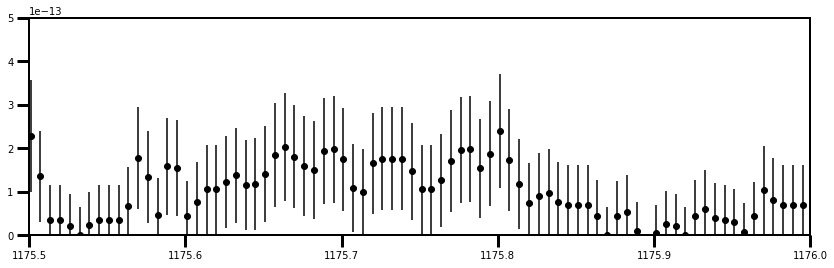

In [42]:
%matplotlib inline

plt.figure(figsize=(14,4))
i = 10
mask = interp_flux[i] > 0
lk = LightCurve(time=finer_wavelength[mask],
                flux=interp_flux[i][mask],
                flux_err=interp_err[i][mask]).bin(binsize=binsize)
plt.errorbar(finer_wavelength[mask],
             interp_flux[i][mask],
             yerr=interp_err[i][mask],
             marker='o', linestyle='', color='k')
plt.errorbar(lk.time.value,
             lk.flux.value,
             yerr=lk.flux_err.value,
             marker='o', linestyle='')
plt.ylim(0,5e-13)
plt.xlim(1175.5,1176)

In [44]:
times = np.zeros((len(fn_b),2))
for i in range(len(fn_b)):
    hdu = fits.open(fn_b[i])
    start = ((hdu[1].header['EXPSTART'] - 59362.14828)*units.day).to(units.s)
    t = [float(i) for i in str(hdu[0].header['HISTORY']).split('was')[-1][1:].split(' to ')]
    times[i][0] = t[0] + start.value
    times[i][1] = t[1] + start.value
    hdu.close()
times = np.nanmedian(times, axis=1)

In [45]:
from astropy.table import Table

In [ ]:
tab = Table()
tab['time_s'] = times
for key in list(widths.keys()):
    tab['ew_'+key] = widths[key]
tab['orbits'] = orbits
tab.write('ew.tab', format='ascii')

In [46]:
np.save('data2_b.npy', [finer_wavelength,
                     interp_flux, 
                     interp_err])
np.save('binned_data2_b.npy', [binned_wavelenth,
                            binned_flux,
                            binned_err])

//anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [47]:
np.save('times2_b.npy', times)
np.save('orbits2_b.npy', orbits)